# Data Analysis

In [1]:
import os
import json
from itertools import islice
import random

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2
from show_annotations import draw_bboxes, draw_landmarks

## Make classification dataset

In [5]:
def cut_faces(data_dir="./new_frames", faces_dir=None):
    """Cutout faces, translate landmarks and save in faces_dir."""
    
    def translate_landmarks(landmarks, bbox_left_x, bbox_top_y):
        """Translate landmarks, using the the bounding box."""
        landmarks_new = []
        for landmark in label["landmarks"]:
            x_new = landmark[0] - bbox_left_x if bbox_left_x < landmark[0] else None
            y_new = landmark[1] - bbox_top_y if bbox_top_y < landmark[1] else None
            landmarks_new.append([x_new, y_new])
        return landmarks_new
    
    for seq in tqdm(os.listdir(data_dir)):
        if not os.path.isdir(os.path.join(data_dir, seq)):
            continue
        
        seq_annots = json.load(open(os.path.join(data_dir, seq, "annotations_final.json")))
        seq_annots_new = {}
        bytes_total = 0
        if not os.path.exists(os.path.join(faces_dir, seq)):
            os.mkdir(os.path.join(faces_dir, seq))
        
        for frame in os.listdir(os.path.join(data_dir, seq)):
            if ".jpg" in frame:
                # print(os.path.join(data_dir, seq, frame))
                img = cv2.imread(os.path.join(data_dir, seq, frame))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                if frame not in seq_annots: continue
                    
                label = seq_annots[frame]

                #plt.title(f"annotation for frame: {frame}, driver_state: {label['driver_state']}")
                #img = draw_bboxes(img, [label["bbox"]])
                #img = draw_landmarks(img, label["landmarks"])
                #plt.imshow(img)
                #plt.show()
                
                left, top, right, bottom = label["bbox"]
                landmarks_new = translate_landmarks(label["landmarks"], left, top)
                
                if None in landmarks_new:
                    raise Exception(f"Landmark outside the bbox, frame: {os.path.join(data_dir, seq, frame)}")
                
                img_face = img[top:bottom, left:right]
                bytes_total += img_face.nbytes
                    
                # plt.title(f"driver_state: {label['driver_state']}")
                # plt.imshow(img_face)
                # plt.imshow(draw_landmarks(img_face, landmarks_new))
                # plt.show()
                
                cv2.imwrite(os.path.join(faces_dir, seq, frame), cv2.cvtColor(img_face, cv2.COLOR_BGR2RGB))
                seq_annots_new[frame] = {}
                seq_annots_new[frame]["driver_state"] = label['driver_state']
                seq_annots_new[frame]["landmarks"] = landmarks_new

        with open(os.path.join(faces_dir, seq, "annotations_final.json"), "w") as file:
            json.dump(seq_annots_new, file)
        
    print(f"bytes_total: {bytes_total}, giga_bytes_total: {bytes_total / 1e9}")
    

cut_faces(data_dir="./frames_extra", faces_dir="./faces/")

100%|███████████████████████████████████████████████████████| 7/7 [01:59<00:00, 17.09s/it]

bytes_total: 180550152, giga_bytes_total: 0.180550152


In [12]:
def collect_annotations(data_dir="./classification_frames"):
    """Collect annotations in the individual files"""
    all_annotations = {}
    for seq in os.listdir(data_dir):
        if not os.path.isdir(os.path.join(data_dir, seq)):
            continue
        seq_annots = json.load(open(os.path.join(data_dir, seq, "annotations_final.json")))
        for frame, frame_label in seq_annots.items():
            all_annotations[os.path.join(data_dir, seq, frame)] = frame_label
    len(all_annotations)

    json.dump(all_annotations, open(os.path.join(data_dir, "annotations_all.json"), "w"))
    return all_annotations

# all_annotations = collect_annotations()
all_annotations = json.load(open("./classification_frames/annotations_all.json"))

In [13]:
TEST_SEQS = [
    "P1042762_720",
    "P1043086_720",
    "P1043081_720",
    "P1042780_720",
    "P1043106_720"
]

def construct_holdout_set(all_annotations, data_dir="./classification_frames"):
    """Construct the holdout set."""
    holdout_annotations = {}
    train_annotations = {}
    
    for k, v in all_annotations.items():
        if k.split("/")[2] in TEST_SEQS:
            holdout_annotations[k] = v
        else:
            train_annotations[k] = v

    json.dump(holdout_annotations, open(os.path.join(data_dir, "annotations_holdout.json"), "w"))
    json.dump(all_annotations, open(os.path.join(data_dir, "annotations_train.json"), "w"))
    
construct_holdout_set(all_annotations)

In [14]:
def val_test_split(val_ratio=0.5, data_dir="./classification_frames", file_name="annotations_holdout.json"):
    """Split the data into a validation and test set."""
    
    all_annotations = json.load(open(os.path.join(data_dir, file_name)))
            
    keys = list(all_annotations.keys())
    random.shuffle(keys)
    all_annotations_s = {}
    for key in keys:
        all_annotations_s[key] = all_annotations[key]
    n_val = int(val_ratio * len(all_annotations_s))
    
    annotations_val = dict(islice(all_annotations_s.items(), n_val))
    annotations_test = dict(list(all_annotations_s.items())[n_val: ])
    print(f"n_val: {len(annotations_val)}, n_test: {len(annotations_test)}")
    
    json.dump(annotations_val, open(os.path.join(data_dir, "annotations_val.json"), "w"))
    json.dump(annotations_test, open(os.path.join(data_dir, "annotations_test.json"), "w"))
    
val_test_split()

n_val: 2502, n_test: 2502


## Dataset statistics

{'alert': 0.7306632165157225, 'microsleep': 0.16630102566987306, 'yawning': 0.10303575781440438}
{'alert': 38967, 'microsleep': 8869, 'yawning': 5495}
class_weights: [2.5662740267405754e-05, 0.00011275228323373548, 0.00018198362147406734]


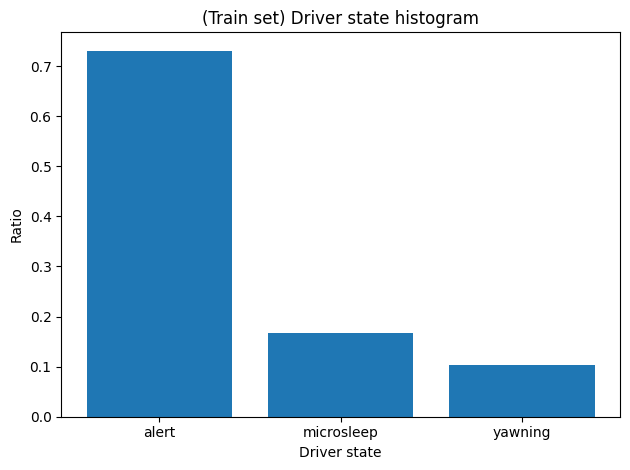

In [15]:
def driver_state_distribution(annotations_file):
    """Compute distribution of driver states"""
    annotations = json.load(open(annotations_file))
    driver_states = {"alert": 0, "microsleep": 0, "yawning": 0}
    for frame, label in annotations.items():
        driver_states[label["driver_state"]] += 1
    driver_states_count = driver_states.copy()

    val_sum = sum(driver_states.values())
    for key, val in driver_states.items():
        driver_states[key] = val / val_sum
    print(driver_states)
    return driver_states_count, driver_states

driver_states_count, driver_states = driver_state_distribution("./classification_frames/annotations_train.json")
plt.bar(list(driver_states.keys()), list(driver_states.values()))
plt.xticks(list(driver_states.keys()))
plt.xlabel('Category')
plt.title("(Train set) Driver state histogram")
plt.xlabel("Driver state")
plt.ylabel("Ratio");
plt.tight_layout()
plt.savefig("./img/train_set_distribution.pdf")
print(driver_states_count)
class_weights = list(1 / count for count in driver_states_count.values())
print(f"class_weights: {class_weights}")

{'alert': 0.7038369304556354, 'microsleep': 0.1486810551558753, 'yawning': 0.1474820143884892}
{'alert': 1761, 'microsleep': 372, 'yawning': 369}
class_weights: [0.0005678591709256105, 0.002688172043010753, 0.0027100271002710027]


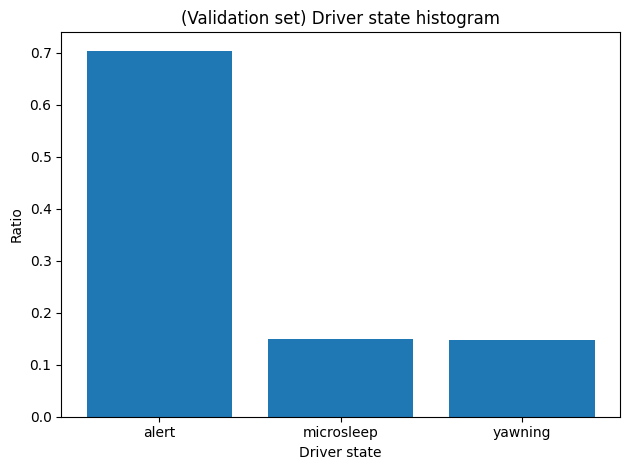

In [16]:

driver_states_count, driver_states = driver_state_distribution("./classification_frames/annotations_val.json")
plt.bar(list(driver_states.keys()), list(driver_states.values()))
plt.xticks(list(driver_states.keys()))
plt.xlabel('Category')
plt.title("(Validation set) Driver state histogram")
plt.xlabel("Driver state")
plt.ylabel("Ratio");
plt.tight_layout()
plt.savefig("./img/val_set_distribution.pdf")
print(driver_states_count)
class_weights = list(1 / count for count in driver_states_count.values())
print(f"class_weights: {class_weights}")

{'alert': 0.6886490807354116, 'microsleep': 0.16906474820143885, 'yawning': 0.14228617106314947}
{'alert': 1723, 'microsleep': 423, 'yawning': 356}
class_weights: [0.0005803830528148578, 0.002364066193853428, 0.0028089887640449437]


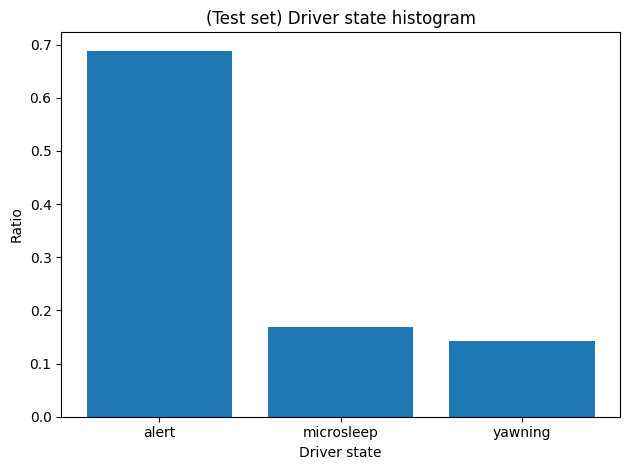

In [17]:
driver_states_count, driver_states = driver_state_distribution("./classification_frames/annotations_test.json")
plt.bar(list(driver_states.keys()), list(driver_states.values()))
plt.xticks(list(driver_states.keys()))
plt.xlabel('Category')
plt.title("(Test set) Driver state histogram")
plt.xlabel("Driver state")
plt.ylabel("Ratio");
plt.tight_layout()
plt.savefig("./img/test_set_distribution.pdf")
print(driver_states_count)
class_weights = list(1 / count for count in driver_states_count.values())
print(f"class_weights: {class_weights}")

In [16]:
def rgb_distribution(annotations_file):
    """Distribution of RGB values in images"""
    annotations = json.load(open(annotations_file))
    r, g, b = np.zeros(256), np.zeros(256), np.zeros(256) 
    for frame in tqdm(annotations.keys()):
        img = cv2.cvtColor(cv2.imread(frame), cv2.COLOR_BGR2RGB)
        r[img[:, :, 0].flatten()] += 1
        g[img[:, :, 1].flatten()] += 1
        b[img[:, :, 2].flatten()] += 1
    return r / r.sum(), g / g.sum(), b / b.sum()

In [17]:
r, g, b = rgb_distribution("./classification_frames/annotations_train.json")

100%|████████████████████████████████████████████████████████| 53331/53331 [01:02<00:00, 855.75it/s]


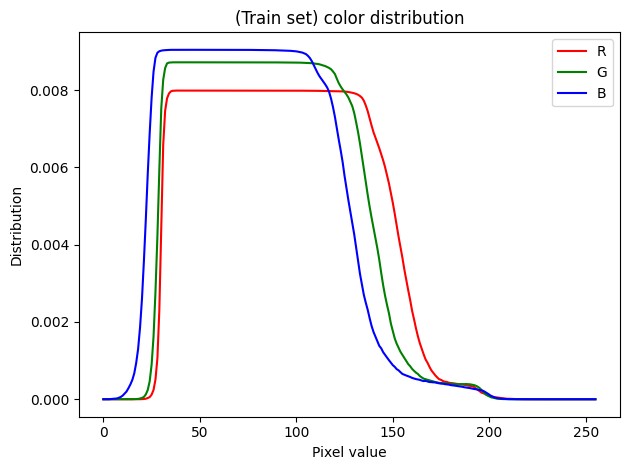

In [18]:
plt.plot(r, color="red", label="R")
plt.plot(g, color="green", label="G")
plt.plot(b, color="blue", label="B")
plt.legend()
plt.title("(Train set) color distribution")
plt.xlabel("Pixel value")
plt.ylabel("Distribution")
plt.tight_layout()
plt.savefig("./img/train_rgb_distribution.pdf")